In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# set the seed for reproductibility
np.random.seed(2)

# Load data

We keep 20% of the training for validation purpose.

In [3]:
train = pd.read_csv('data/auto-insurance-fall-2017/train_auto.csv', index_col=0)
train, val = train_test_split(train, test_size=0.2)
test = pd.read_csv('data/auto-insurance-fall-2017/test_auto.csv', index_col=0)

# Inspection of the data and first remarks

In [4]:
train.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
9111,0,0.0,1,45.0,2,14.0,"$107,663",No,"$389,586",Yes,...,"$15,300",4,Minivan,no,"$26,455",1,No,5,19.0,Highly Urban/ Urban
9252,0,0.0,0,48.0,0,14.0,"$114,544",No,"$326,091",Yes,...,"$9,910",7,Pickup,no,"$6,555",4,No,0,11.0,Highly Urban/ Urban
2735,0,0.0,0,43.0,2,16.0,"$50,308",No,"$187,532",Yes,...,"$13,380",11,Minivan,yes,$0,0,No,0,9.0,Highly Urban/ Urban
1216,1,1133.0,0,49.0,0,14.0,"$45,689",No,"$250,792",Yes,...,"$10,970",4,Pickup,yes,$0,0,No,0,1.0,Highly Urban/ Urban
6745,0,0.0,0,58.0,0,13.0,"$65,131",No,"$236,533",Yes,...,"$7,300",10,Pickup,yes,"$6,334",1,No,4,21.0,Highly Urban/ Urban


The dataset contains numerical data, as well as categorical data and numerical under a string format.

We drop the column `TARGET_AMT` since it should not be used in this project.

In [5]:
train = train.drop('TARGET_AMT',axis=1)
val = val.drop('TARGET_AMT',axis=1)
test = test.drop('TARGET_AMT',axis=1)

In [6]:
train.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,6528.000000,6528.000000,6523.000000,6528.000000,6174.000000,6528.000000,6528.000000,6528.000000,6528.000000,6123.000000
mean,0.262868,0.165748,44.732332,0.714154,10.467930,33.492953,5.371630,0.788297,1.706955,8.310795
std,0.440225,0.499220,8.631371,1.109634,4.096067,15.920217,4.163732,1.155944,2.158440,5.677313
min,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,27.000000


We already notice from the mean of the `TARGET_FLAG` field that we will have to face class imblalance in the following.

In [7]:
train.isna().sum()

TARGET_FLAG      0
KIDSDRIV         0
AGE              5
HOMEKIDS         0
YOJ            354
INCOME         354
PARENT1          0
HOME_VAL       367
MSTATUS          0
SEX              0
EDUCATION        0
JOB            424
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        405
URBANICITY       0
dtype: int64

Likewise, there is a number of missing data, which will require a specific processing.

# Preprocessing

Format and convert money data to numerical values.

In [8]:
def money2float(df):
    # inplace conversion of str money data to floats
    for col in df.columns:
        df[col] = df[col].apply(lambda x: float(x[1:].replace(',','')) if (type(x)==str and x.startswith('$')) else x)
money2float(train)
money2float(val)
money2float(test)

Formatting of categorical data with one hot encoding

In [9]:
def one_hot_str(df):
    one_hot_df = df.copy()
    for col in df.columns:
        if type(df[col][df.index[0]])==str:
            for val in set(df[col]):
                if type(val)==str:
                    one_hot_df[f'{col}_{val}'] = (df[col]==val).astype(int)
                else:
                    one_hot_df[f'{col}_{val}'] = (df[col].isna()).astype(int)
                # if the categorical data is binary, then we do not create a second field
                if len(set(df[col])) == 2:
                    break
            one_hot_df = one_hot_df.drop(col, axis=1)
    return one_hot_df

train = one_hot_str(train)
val = one_hot_str(val)
test = one_hot_str(test)

Separate observation data and target data

In [10]:
train_Y = train[['TARGET_FLAG']]
train_X = train.drop('TARGET_FLAG', axis=1)

val_Y = val[['TARGET_FLAG']]
val_X = val.drop('TARGET_FLAG', axis=1)

test_X = test.drop('TARGET_FLAG', axis=1)

Compute weights for class balancing

In [11]:
from sklearn.utils.class_weight import compute_sample_weight

train_sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=train_Y.values
)
val_sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=val_Y.values
)

Normalizing data with the statistics of the training set to avoid scale bias

In [12]:
val_X = (val_X - train_X.mean()) / train_X.std()
test_X = (test_X - train_X.mean()) / train_X.std()
train_X = (train_X - train_X.mean()) / train_X.std()

Fill nan values with mean value (0 after normalization)

In [13]:
train_X = train_X.fillna(0)
val_X = val_X.fillna(0)
test_X = test_X.fillna(0)

Sanity check

In [14]:
train_X.describe()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,...,CAR_USE_Commercial,CAR_TYPE_Sports Car,CAR_TYPE_Minivan,CAR_TYPE_z_SUV,CAR_TYPE_Van,CAR_TYPE_Pickup,CAR_TYPE_Panel Truck,RED_CAR_no,REVOKED_Yes,URBANICITY_z_Highly Rural/ Rural
count,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,...,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03
mean,3.864012e-17,1.706152e-16,5.551115e-17,-1.545605e-16,-1.523836e-17,2.775558e-17,4.353816e-17,5.659961e-17,-5.224579e-17,1.197299e-17,...,7.074951e-18,-5.006888e-17,5.170156e-17,8.925322e-17,-1.959217e-17,6.530724e-18,-1.306145e-17,-2.884403e-17,-2.312965e-17,4.353816e-17
std,1.000000e+00,9.996169e-01,1.000000e+00,9.725039e-01,9.725039e-01,9.714793e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.320132e-01,-3.328826e+00,-6.435947e-01,-2.555605e+00,-1.295006e+00,-1.193386e+00,-1.789734e+00,-1.679876e+00,-1.049931e+00,-4.535303e-01,...,-7.704927e-01,-3.545308e-01,-5.978294e-01,-6.278659e-01,-3.125402e-01,-4.521026e-01,-3.017904e-01,-1.565812e+00,-3.787291e-01,-5.074660e-01
25%,-3.320132e-01,-6.641276e-01,-6.435947e-01,-3.583755e-01,-6.741649e-01,-1.193386e+00,-7.219094e-01,-7.633850e-01,-1.049931e+00,-4.535303e-01,...,-7.704927e-01,-3.545308e-01,-5.978294e-01,-6.278659e-01,-3.125402e-01,-4.521026e-01,-3.017904e-01,-1.565812e+00,-3.787291e-01,-5.074660e-01
50%,-3.320132e-01,3.101109e-02,-6.435947e-01,1.298978e-01,-9.671002e-02,0.000000e+00,-3.096399e-02,-1.492418e-01,-3.294232e-01,-4.535303e-01,...,-7.704927e-01,-3.545308e-01,-5.978294e-01,-6.278659e-01,-3.125402e-01,-4.521026e-01,-3.017904e-01,6.385486e-01,-3.787291e-01,-5.074660e-01
75%,-3.320132e-01,7.261498e-01,2.576035e-01,6.181710e-01,4.454789e-01,6.089773e-01,6.599814e-01,6.104651e-01,3.910842e-01,5.805446e-02,...,1.297672e+00,-3.545308e-01,1.672462e+00,1.592453e+00,-3.125402e-01,-4.521026e-01,-3.017904e-01,6.385486e-01,-3.787291e-01,-5.074660e-01
max,7.680491e+00,4.201843e+00,3.862396e+00,3.059537e+00,6.416438e+00,5.654138e+00,6.815677e+00,6.379573e+00,4.714129e+00,5.715081e+00,...,1.297672e+00,2.820198e+00,1.672462e+00,1.592453e+00,3.199099e+00,2.211549e+00,3.313050e+00,6.385486e-01,2.640005e+00,1.970274e+00


# Data visualization

In [15]:
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Target against variables

We plot the distribution of values of each variable conditionally to the target tag, in order to identify potentially highly discriminative variables.

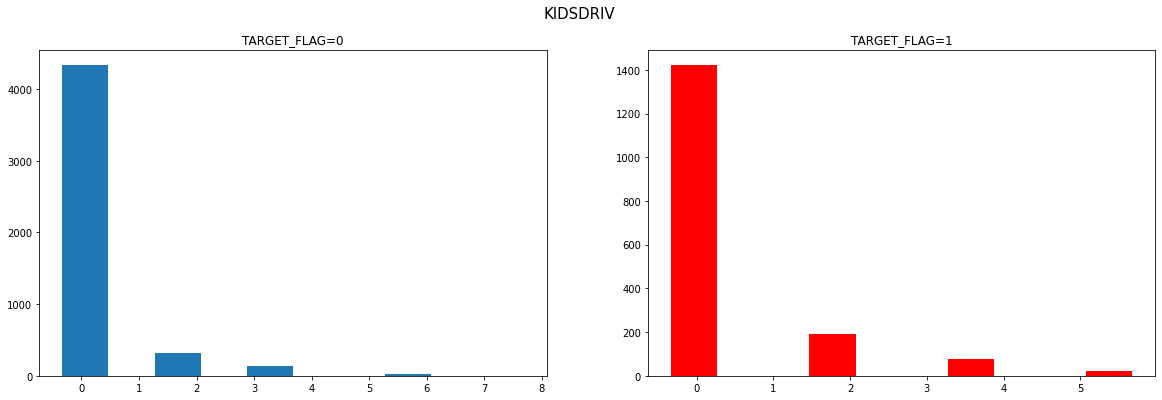

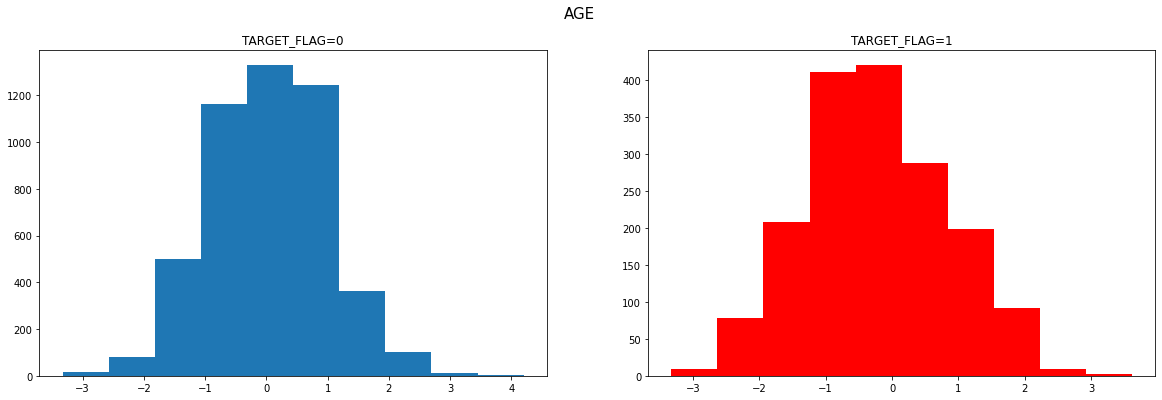

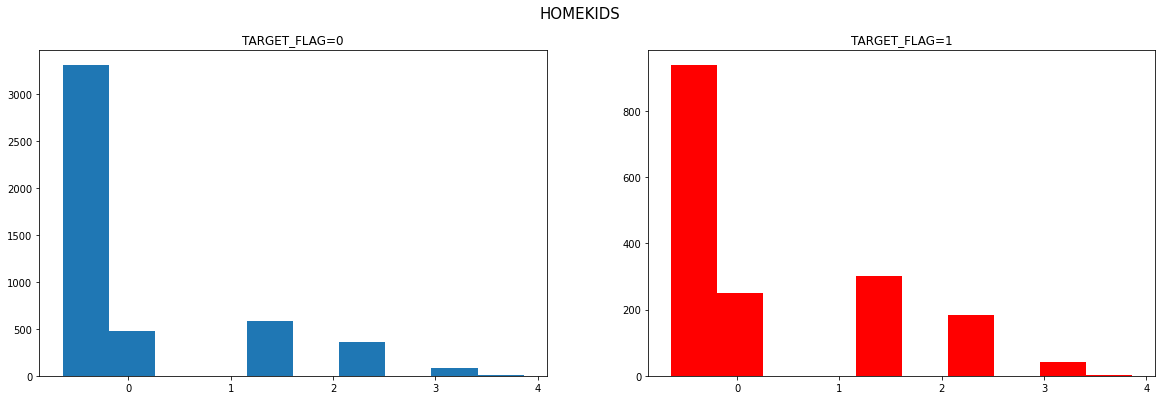

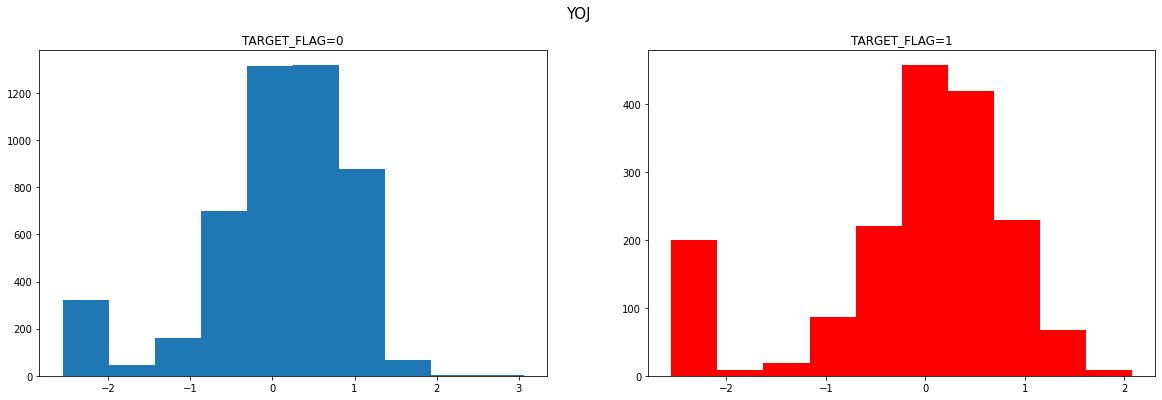

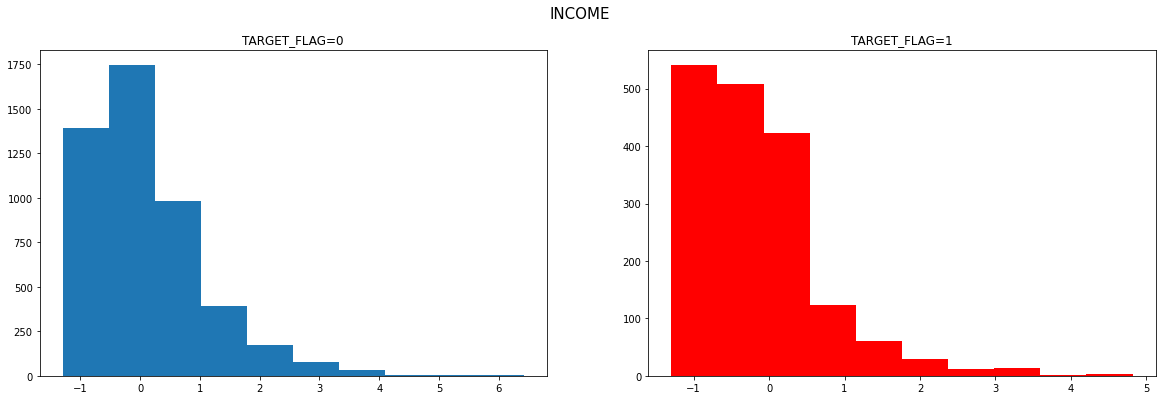

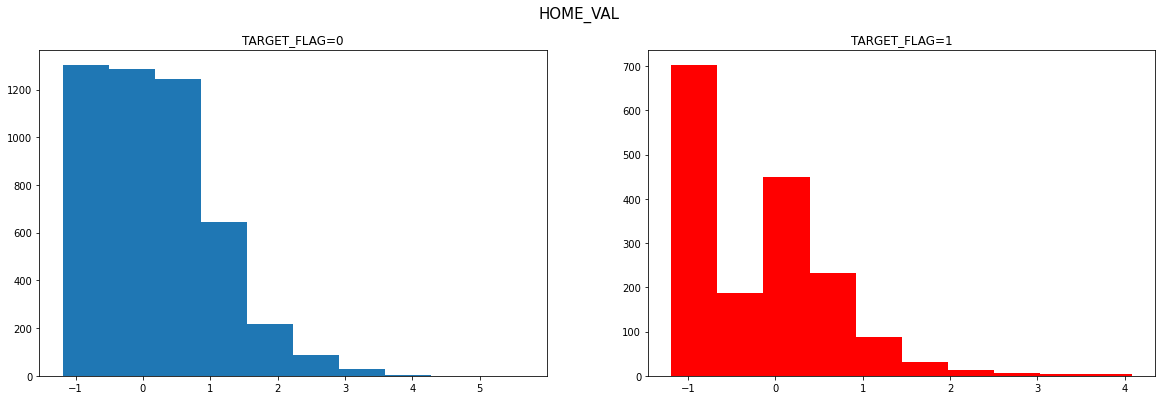

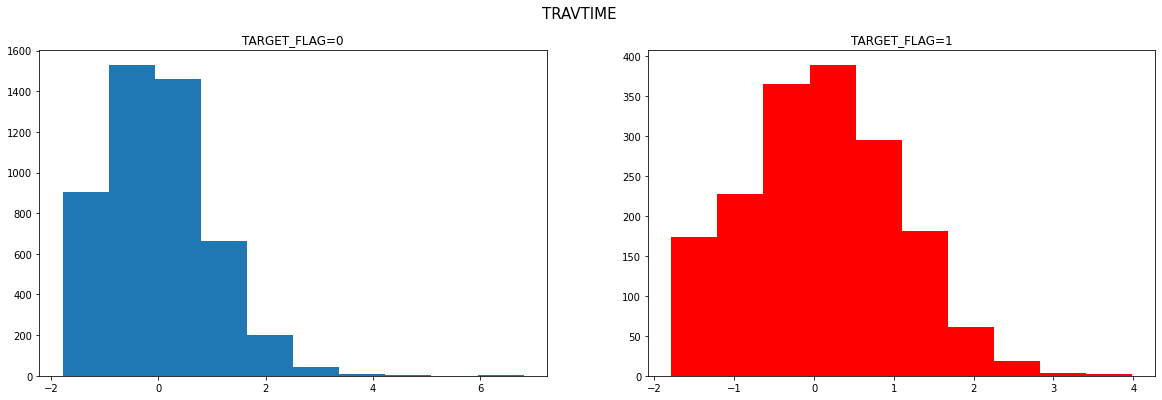

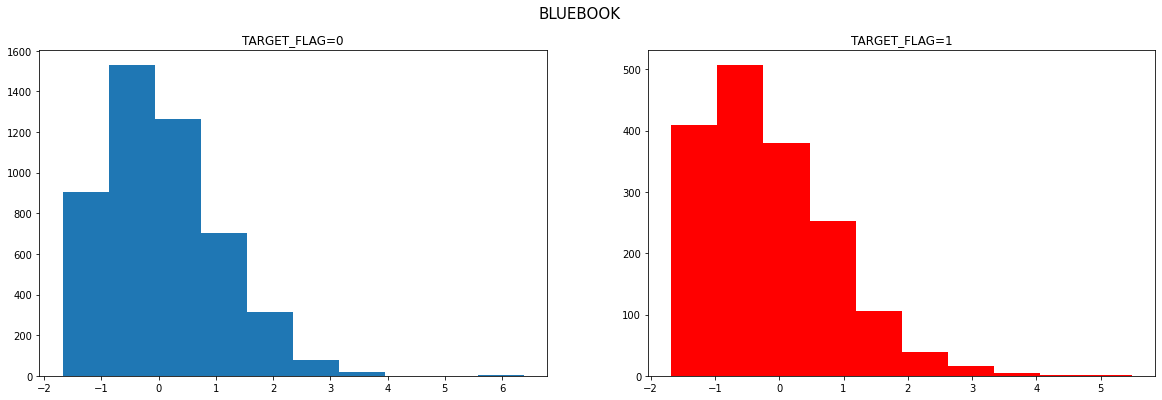

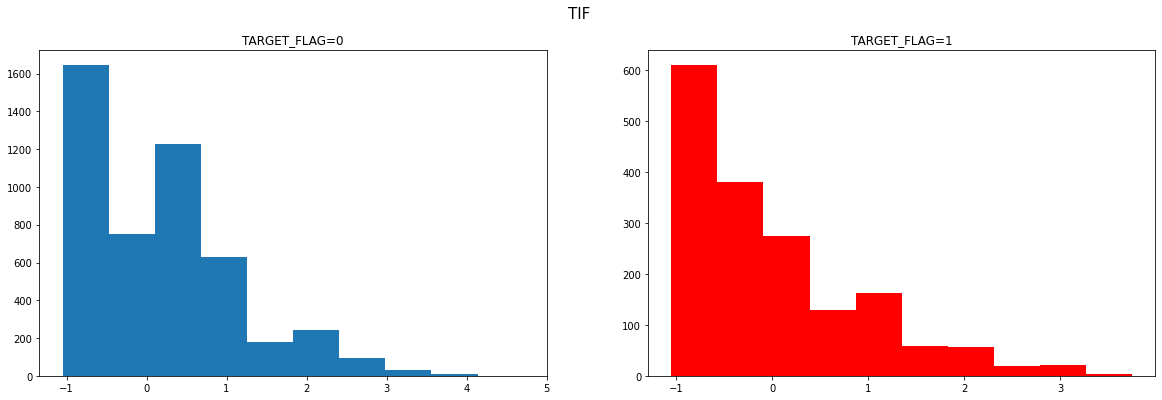

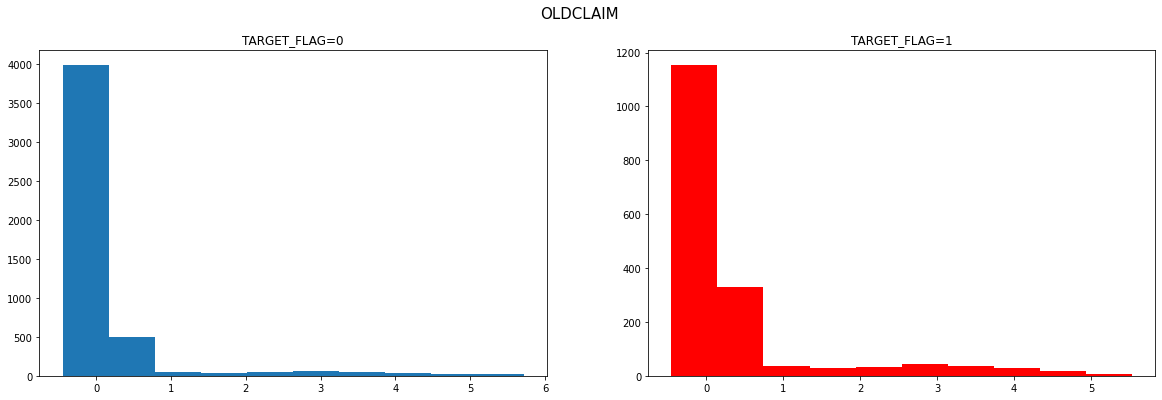

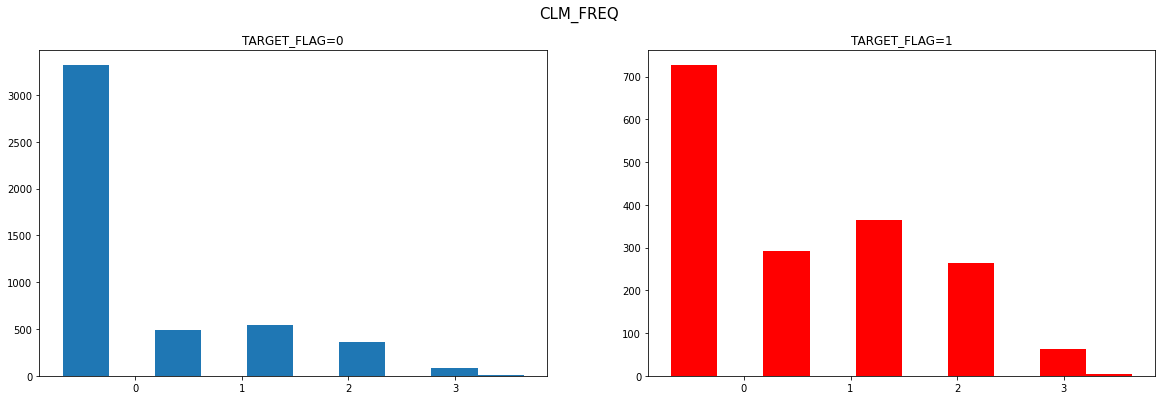

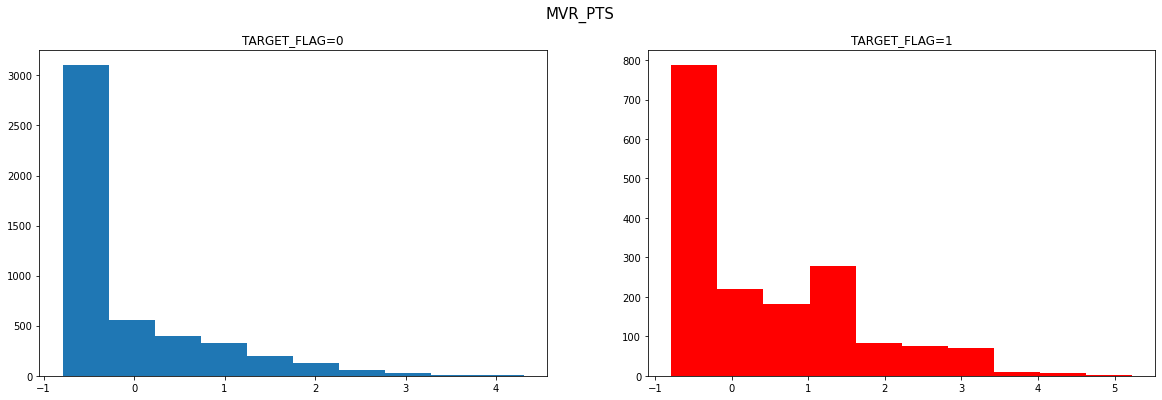

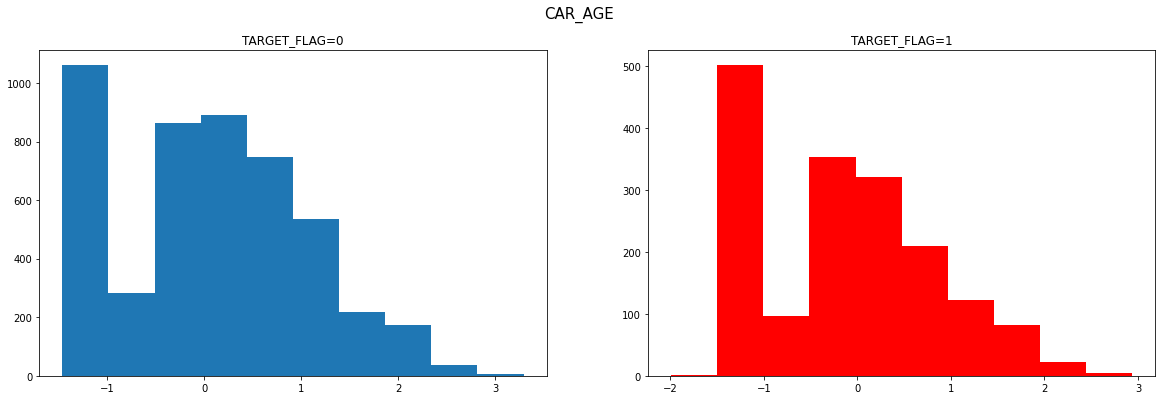

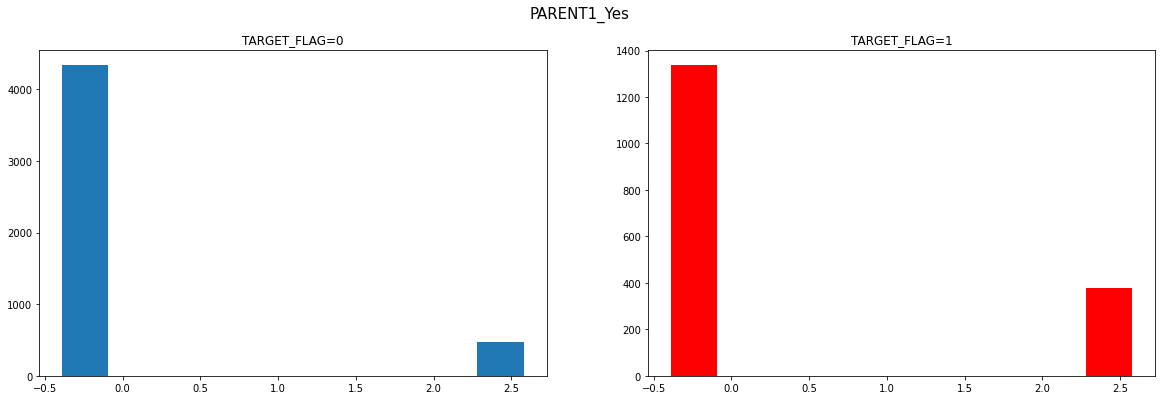

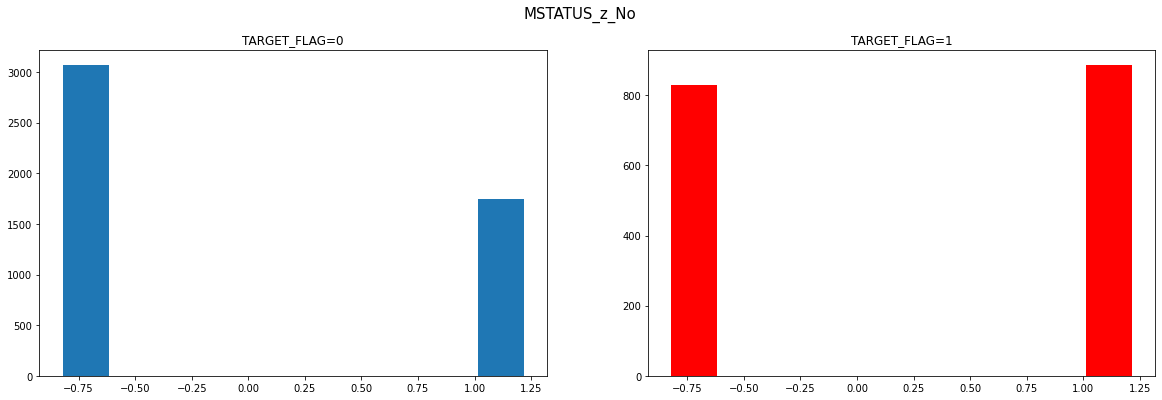

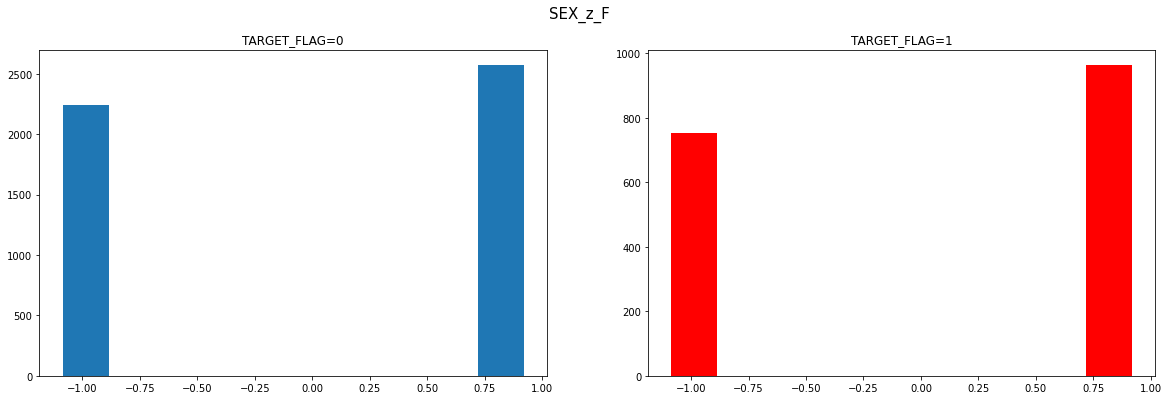

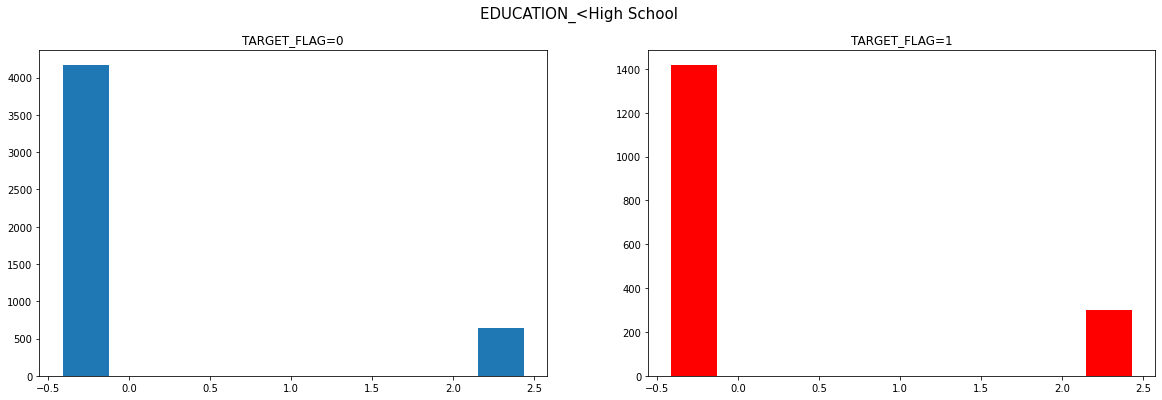

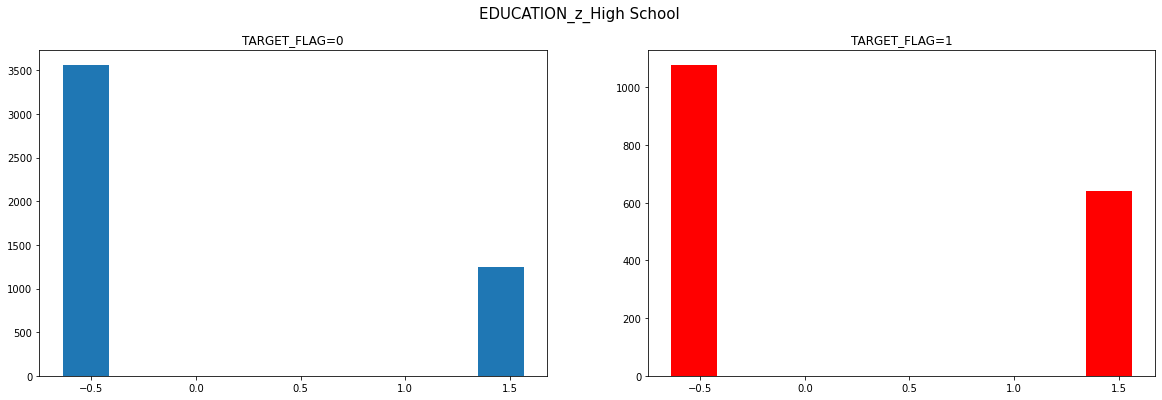

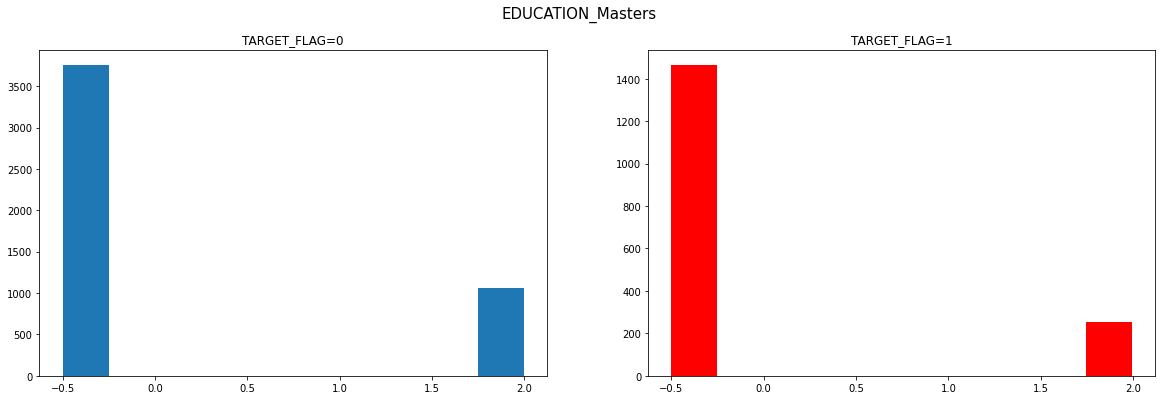

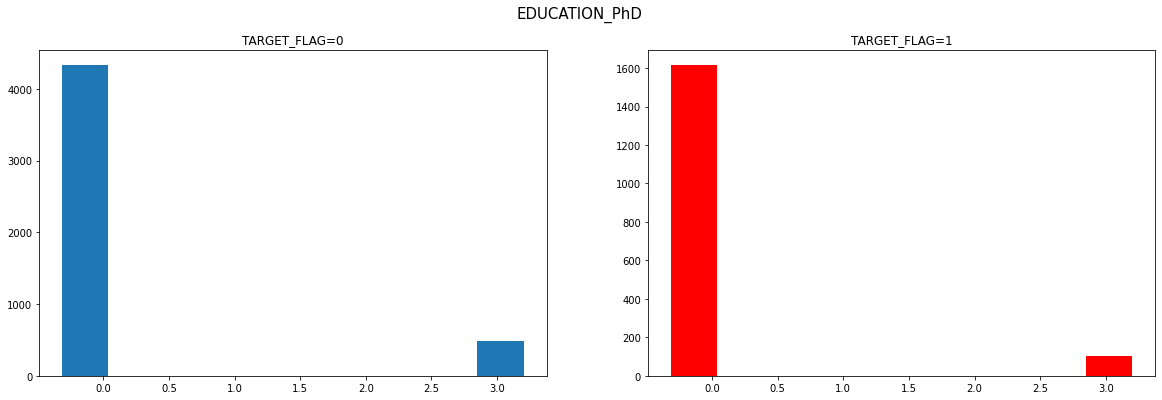

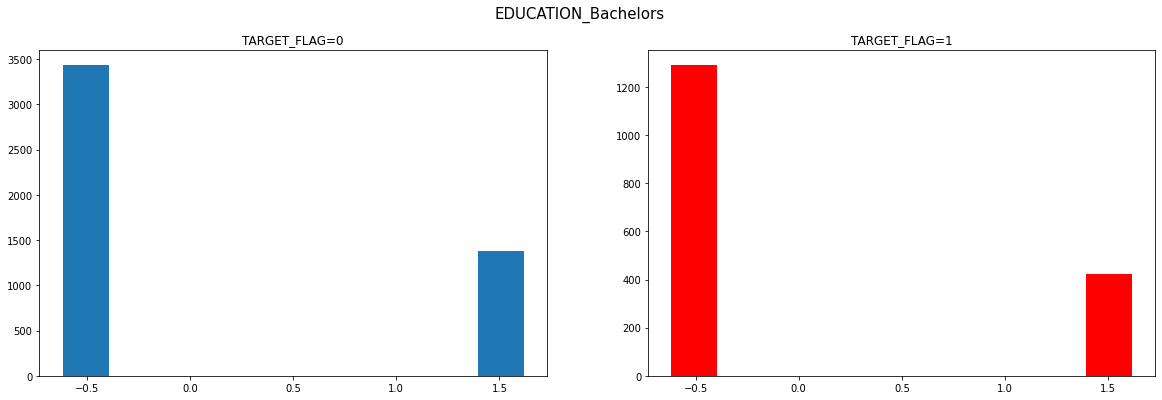

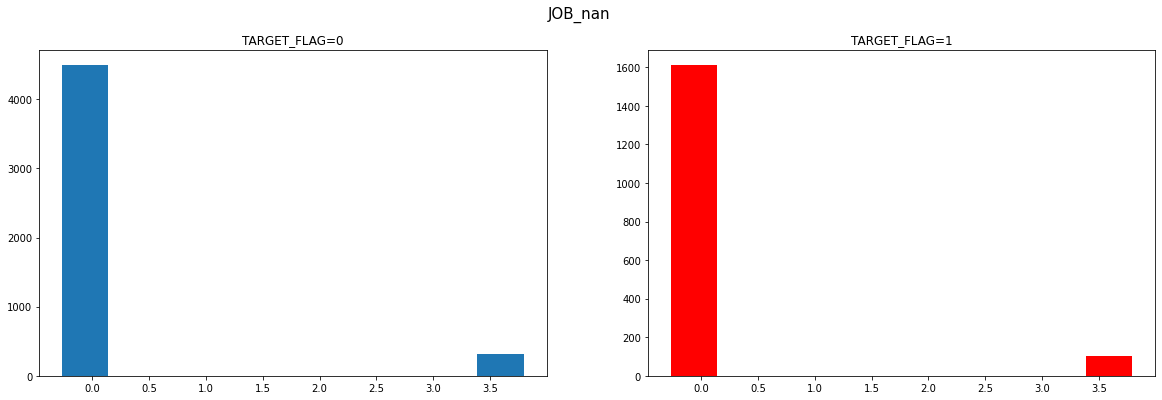

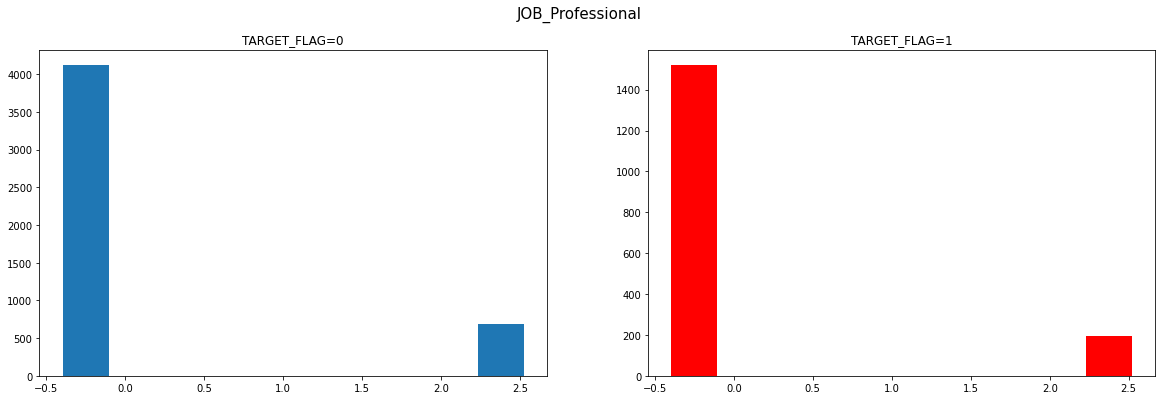

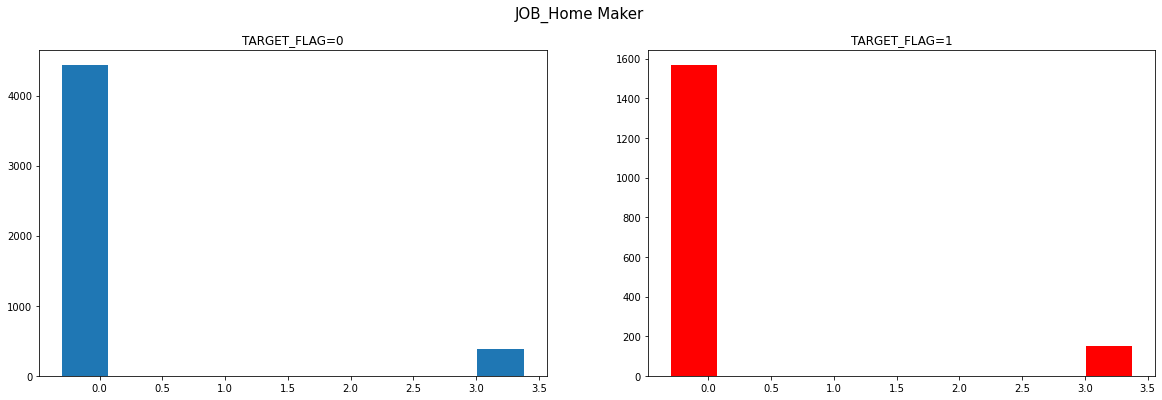

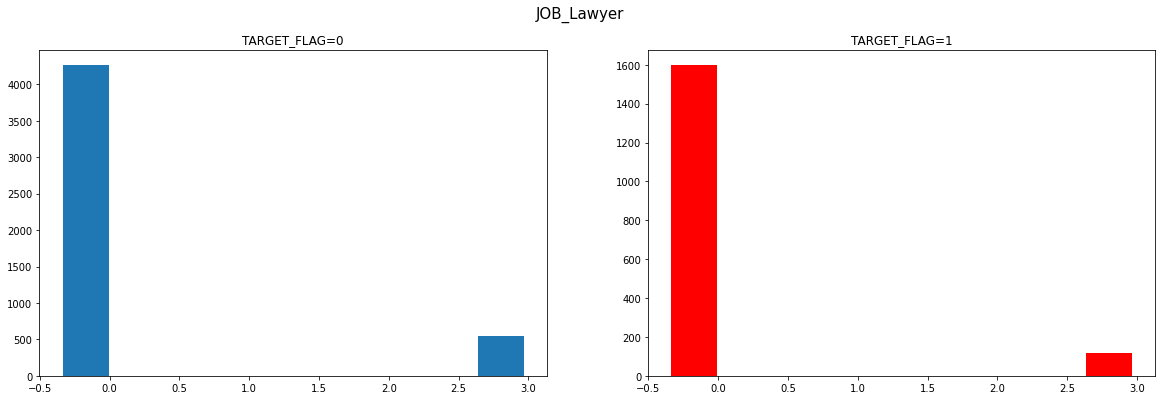

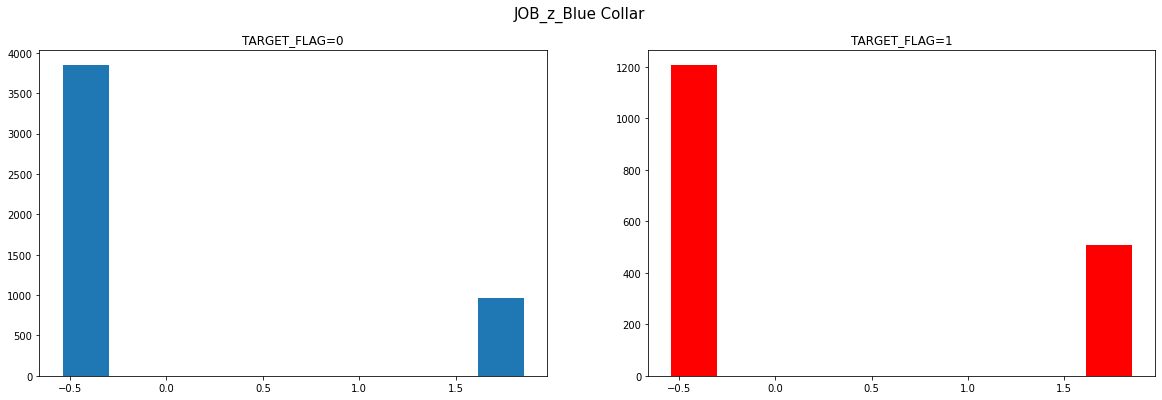

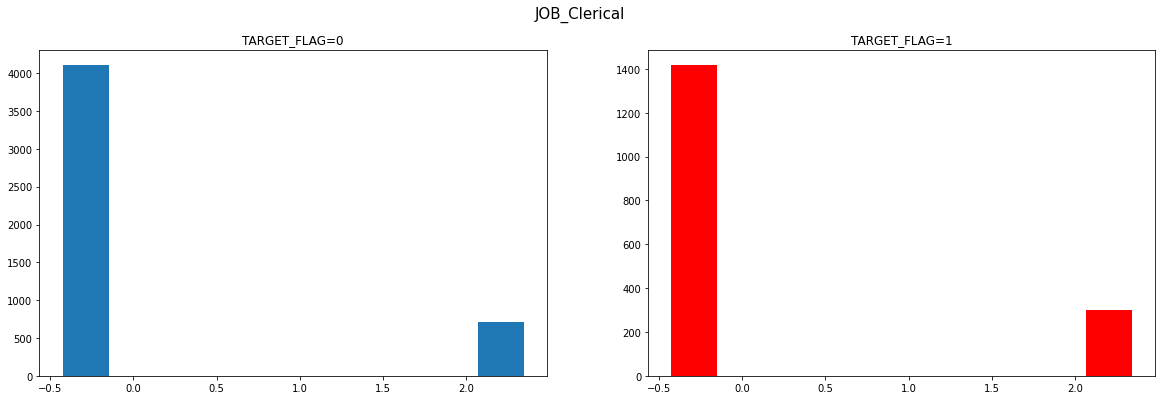

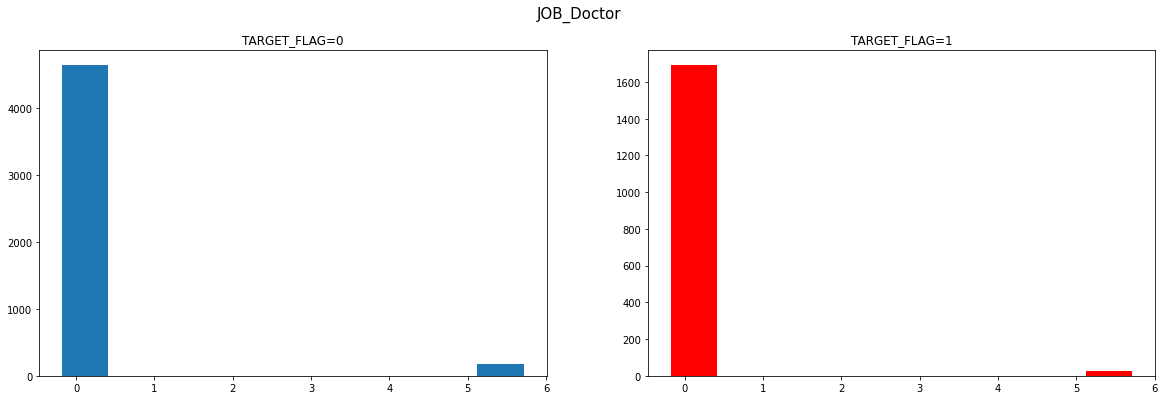

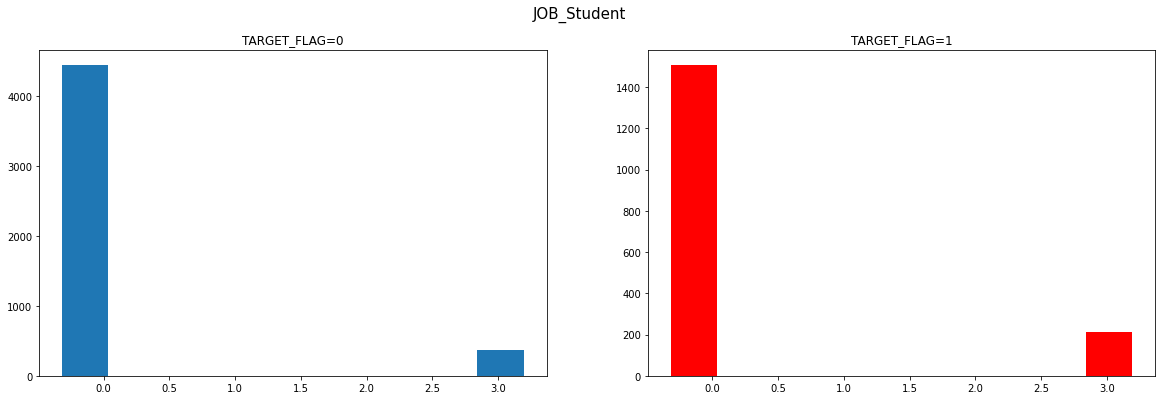

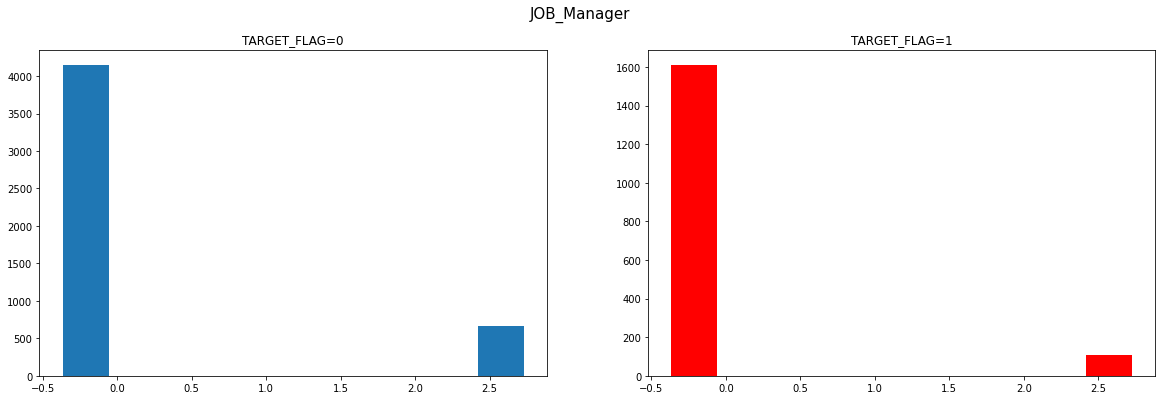

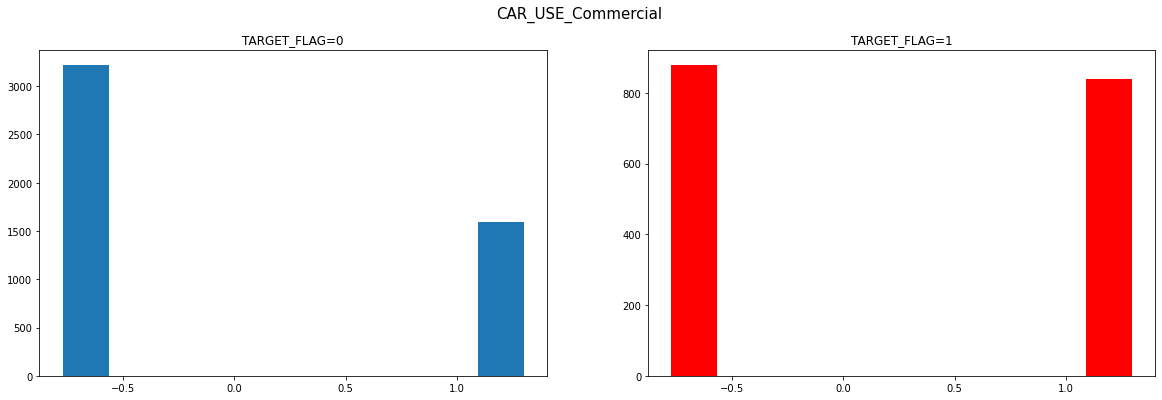

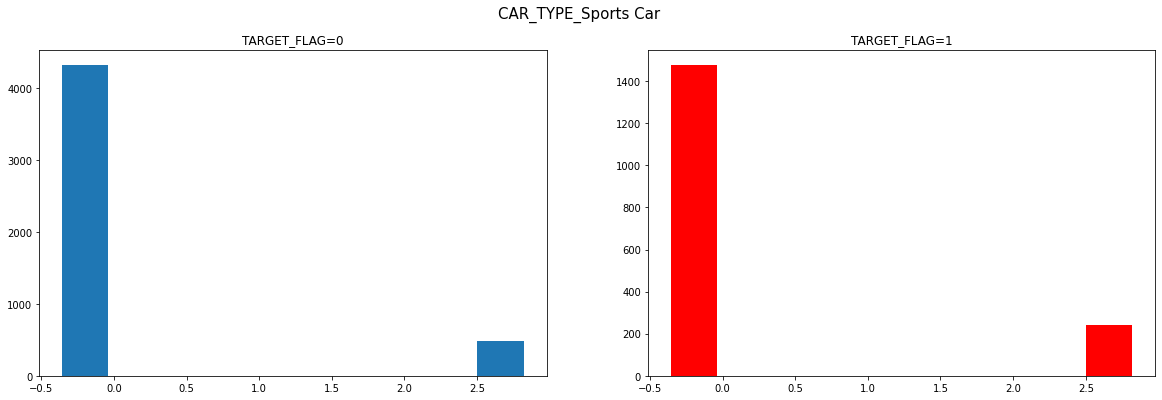

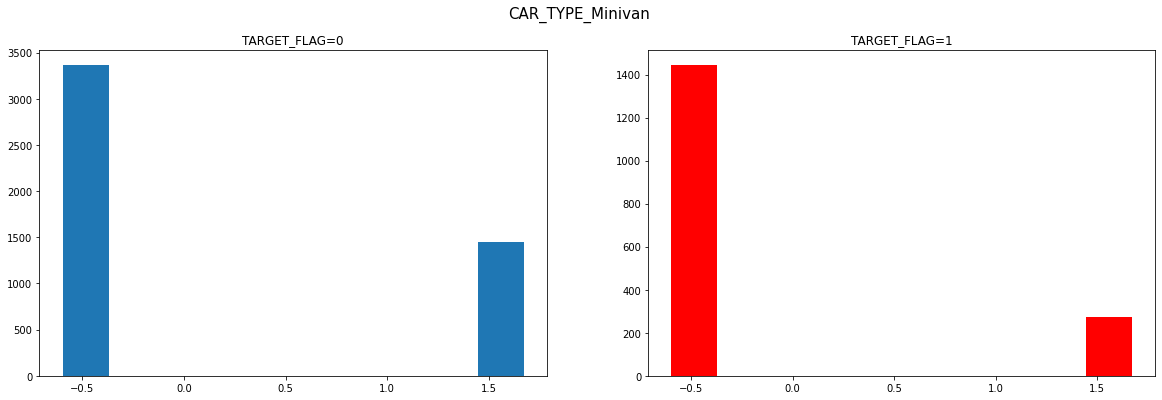

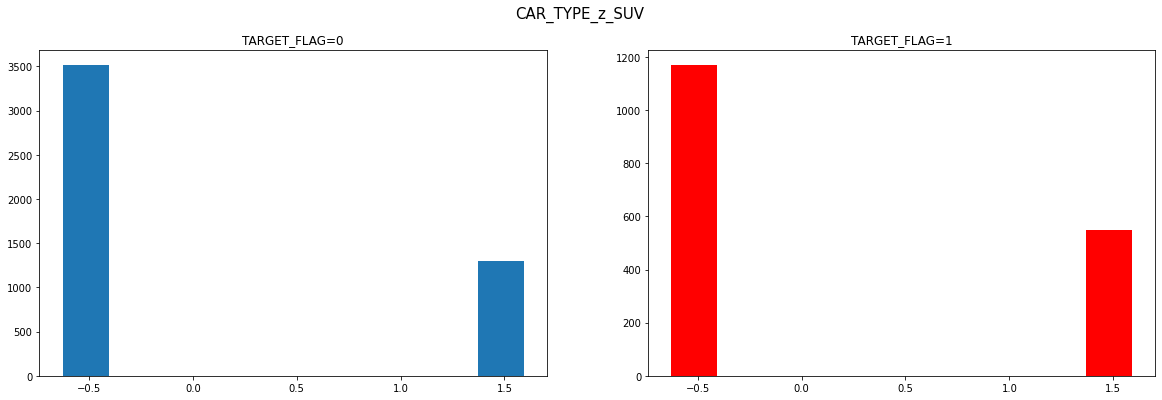

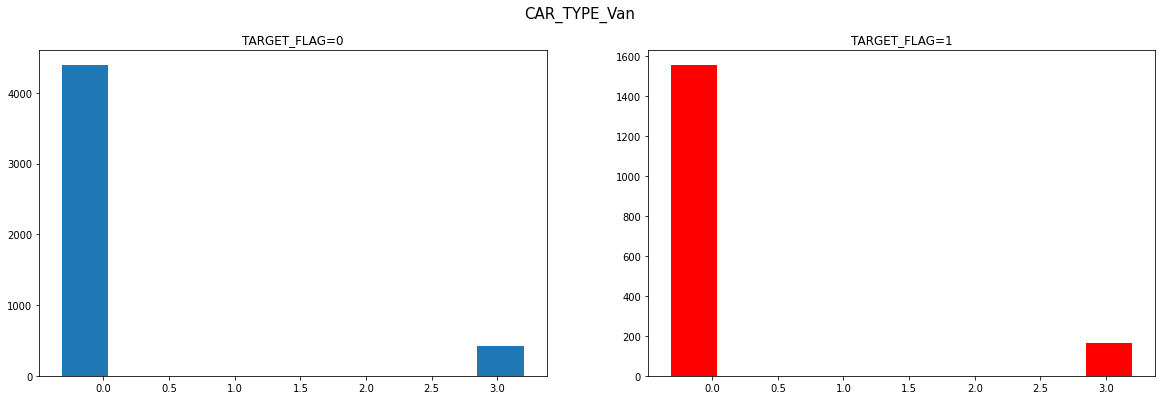

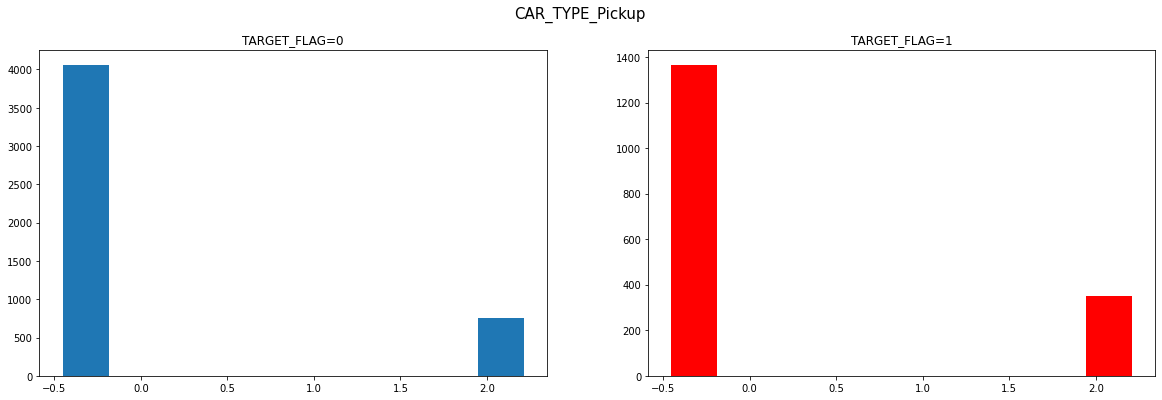

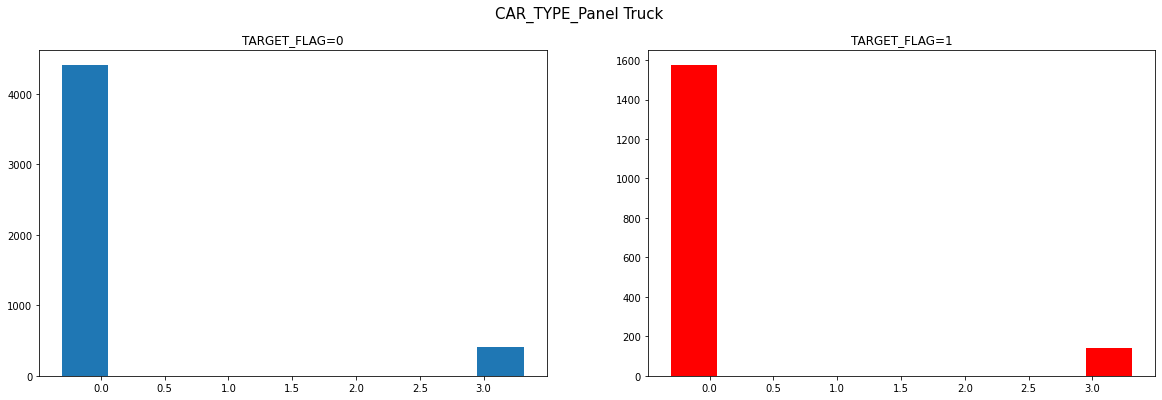

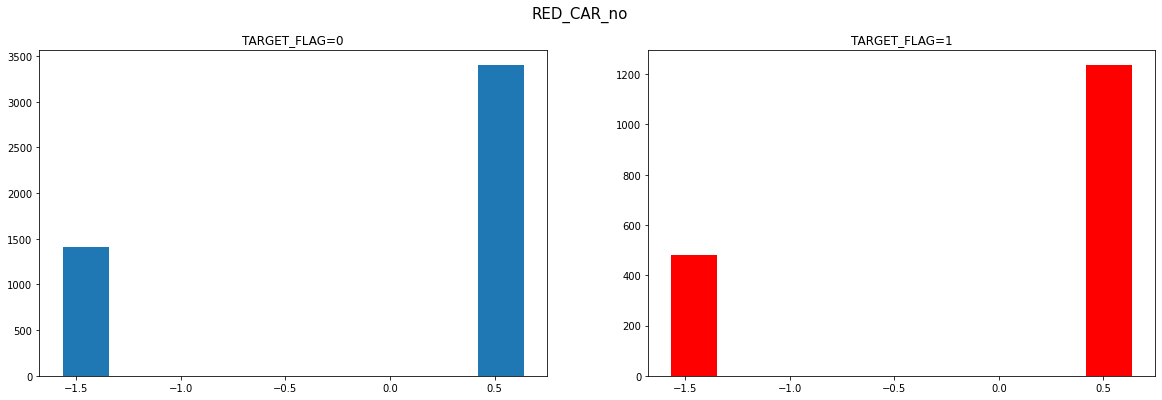

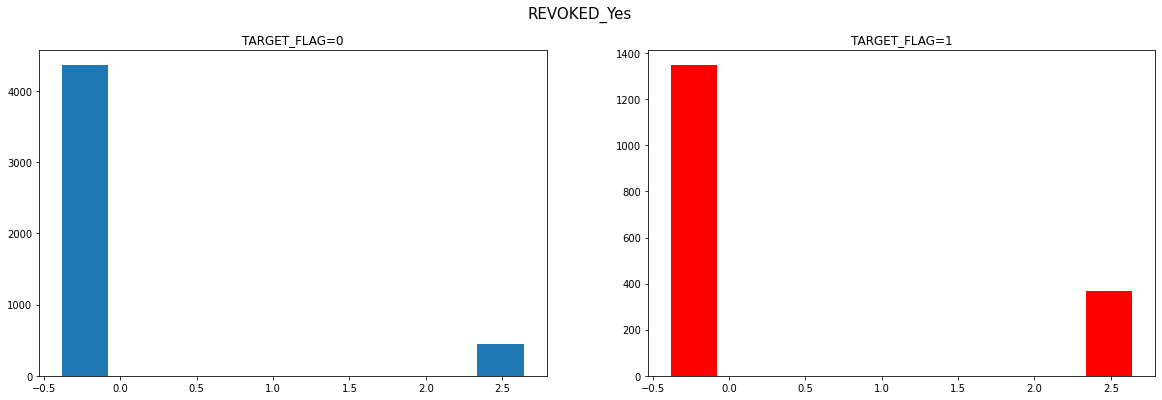

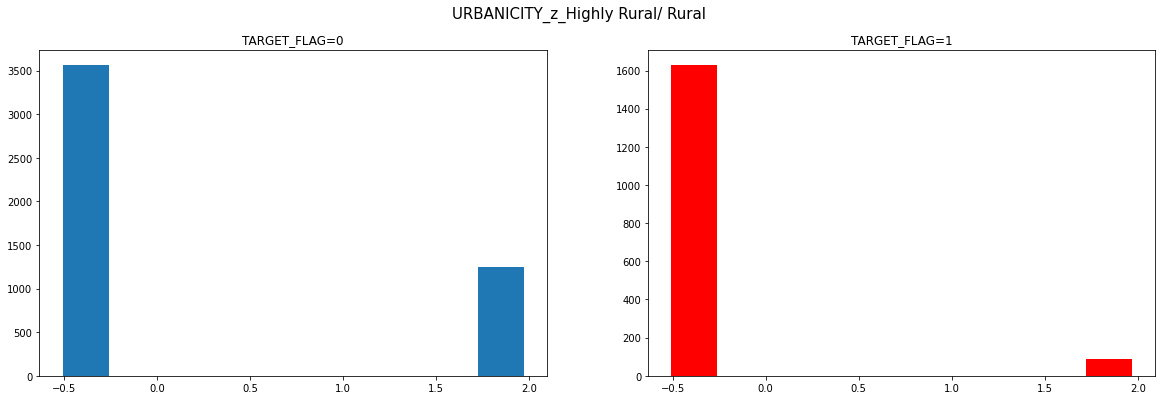

In [16]:
for col in train_X.columns:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    ax[0].hist(train_X[train_Y.TARGET_FLAG==0][col])
    ax[0].set_title('TARGET_FLAG=0')
    ax[1].hist(train_X[train_Y.TARGET_FLAG==1][col], color='r')
    ax[1].set_title('TARGET_FLAG=1')
    plt.suptitle(col, size=15)
    plt.show()

The visual comparison of the distribution does not allow to identify any clear discriminative variable, even if some trends can be observed for some variables : for instance, the distribution of the variable `AGE` is slightly centered towards positive value when `TARGET_FLAG=0`, while it is centered towards negative values when `TARGET_FLAG=0`.

## 2D PCA

On a similar idea, let's plot the 2D PCA of the observation variables in order to check if a clear separation can be observed.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


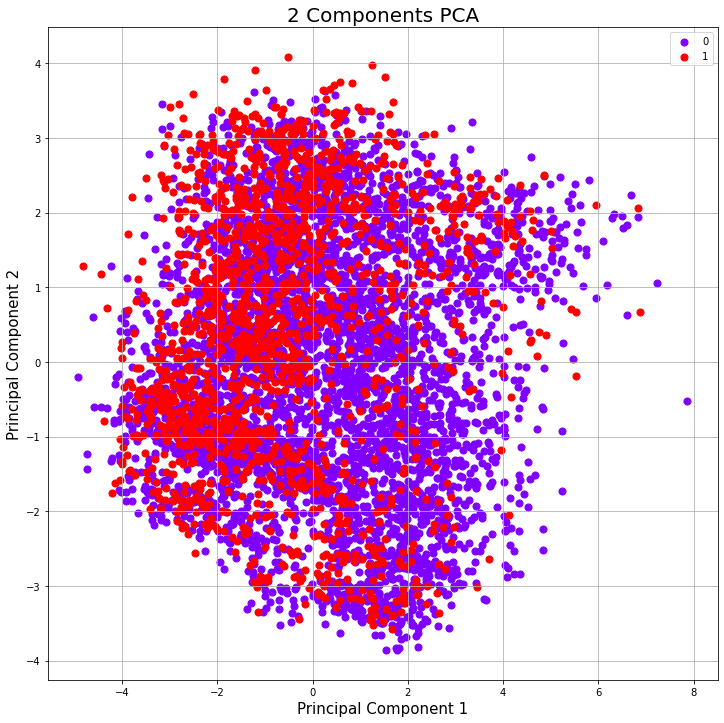

In [17]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_X)
var = pca.explained_variance_ratio_

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf["label"] = list(train_Y.TARGET_FLAG)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Components PCA', fontsize = 20)


labels = set(list(principalDf["label"]))
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(labels)))

for label, color in zip(labels,colors):
    indicesToKeep = principalDf['label'] == label
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()
plt.show()

Once again, there is no clear separation but one can notice that the class `TARGET_FLAG=1` is under represented in the middle-right area of the PCA compared to the other class. In order to get further interpretation on this, we can have a look at the 5 variables with the highest contribution to each axis of the PCA.

In [18]:
compo=pca.components_
cols = train_X.columns
for j in range(2):
    print("Component "+str(j+1))
    print("============")
    sorted_idxs = np.argsort(np.abs(compo[j]))[::-1]
    for i in range(5):
        col_idx = sorted_idxs[i]
        print(str(cols[col_idx])+" : "+str(compo[j][col_idx]))
    print("")
    print("")

Component 1
INCOME : 0.360224066069258
CAR_AGE : 0.28323946853345355
HOME_VAL : 0.2716129829731862
BLUEBOOK : 0.2612894383319398
EDUCATION_Masters : 0.2306831752057528


Component 2
CAR_USE_Commercial : 0.41160339384843314
SEX_z_F : -0.3918736325882117
RED_CAR_no : -0.33268436444201865
CAR_TYPE_z_SUV : -0.2884350300242621
JOB_Lawyer : -0.26480063399670734




This may give a potential hint about the observed under-representation but is not in any case a reliable analysis.

Another remark about this section, is that the visual inspection of the variable distributions and of the 2D-PCA allows to assume that there is no obvious outlier in the data. In the contrary case, we should have done an additional processing step to remove outliers by performing a threshold on the z-score for example.

# Model zoo

Since we have no a priori on the classification task (ie if recall should be preferred over precision for instance), we will use the weighted f1 score as the performance metric in order to get a balanced evaluation between classes, as well as a balanced importance of both precision  and recall.

If the final performance of the model was a important objective, it should be interesting to perform cross-validation for each of the following proposed models in order to determine the hyperparameters giving the best performance.

In [19]:
from sklearn.metrics import classification_report

## Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(train_X, train_Y, sample_weight=train_sample_weight)

# convert to binary prediction
preds = (np.clip(lin_reg.predict(val_X), 0, 1) + .5).astype(int)
print(classification_report(preds, val_Y, sample_weight=val_sample_weight))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72 792.7854251012054
           1       0.74      0.72      0.73 840.2145748987778

    accuracy                           0.73 1632.9999999999832
   macro avg       0.73      0.73      0.73 1632.9999999999832
weighted avg       0.73      0.73      0.73 1632.9999999999832



## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg = log_reg.fit(train_X, train_Y, sample_weight=train_sample_weight)

# convert to binary prediction
preds = (np.clip(log_reg.predict(val_X), 0, 1) + .5).astype(int)
print(classification_report(preds, val_Y, sample_weight=val_sample_weight))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72 814.5597165991802
           1       0.72      0.72      0.72 818.4402834008026

    accuracy                           0.72 1632.9999999999827
   macro avg       0.72      0.72      0.72 1632.9999999999827
weighted avg       0.72      0.72      0.72 1632.9999999999827



## Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth=7)
random_forest = random_forest.fit(train_X, train_Y, sample_weight=train_sample_weight)
print(classification_report(random_forest.predict(val_X), val_Y, sample_weight=val_sample_weight))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72 860.4797570850083
           1       0.68      0.72      0.70 772.5202429149741

    accuracy                           0.71 1632.9999999999823
   macro avg       0.71      0.71      0.71 1632.9999999999823
weighted avg       0.71      0.71      0.71 1632.9999999999823



## XGBoost

In [23]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(train_X.values, train_Y.values, sample_weight=train_sample_weight)
print(classification_report(model_xgb.predict(val_X), val_Y, sample_weight=val_sample_weight))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75 1000.4676113360141
           1       0.60      0.78      0.68 632.5323886639652

    accuracy                           0.72 1632.9999999999793
   macro avg       0.72      0.73      0.71 1632.9999999999793
weighted avg       0.74      0.72      0.72 1632.9999999999793



# Inference on test set

The different models have similar performance, but the linear regression eventually gets the best performance with the chosen metric, so we keep it as our final model.

In [24]:
final_model = lin_reg
test_preds = (np.clip(final_model.predict(test_X), 0, 1) + .5).astype(int).squeeze()

In [25]:
res_csv = pd.DataFrame({'PRED_TARGET_FLAG': test_preds}, index=test.index)
res_csv.to_csv('test_preds.csv')